# Finetune with standardized targets
The settings follow `finetune_02.ipynb`. The only difference are that (1) the targets and predictions are standardized before feeding into the loss function, (2) the zero and negative values of CaCO3 are replaced with 0.001. 

__All the masking codes are removed in the finetune model after checking with the MAE paper, codes and tutorials.__

```
ViT model: base
Base learning rates: 1e-4, 1e-5, 1e-6, 1e-7
Optimizer: AdamW (betas=((0.9, 0.999)), weight_decay=0.05) 
Data pre-processing: spectrum-wise standardization
Patch size: 16
Batch size: 256
Epochs: 100 (warmup: 20)
```
Details please refer to `models_regressor.py`, `engine_finetune` and `main_finetune.py`.


In [6]:
import pandas as pd

lr_df = pd.read_csv('results/tuning_lr_20240116.csv')
lr_df

,lr,min_val_loss
0,1.000000e-04,1.182339
1,1.000000e-05,1.082628
2,1.000000e-06,0.631548
3,1.000000e-07,2.169284


Text(0, 0.5, 'Validation loss after 100 epochs')

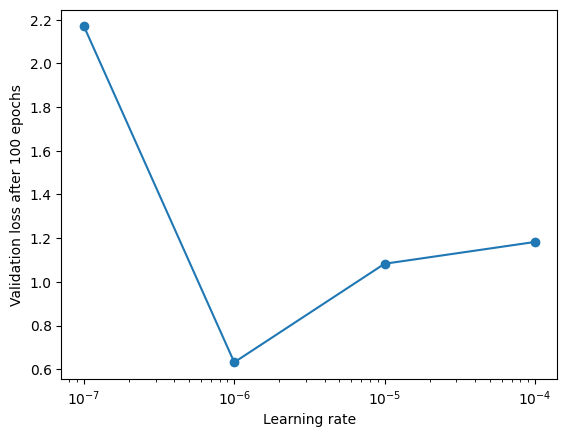

In [7]:
import matplotlib.pyplot as plt
plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Validation loss after 100 epochs')

________________________________________________________________________________
Learning rate: 0.0001
Validation loss: 1.2


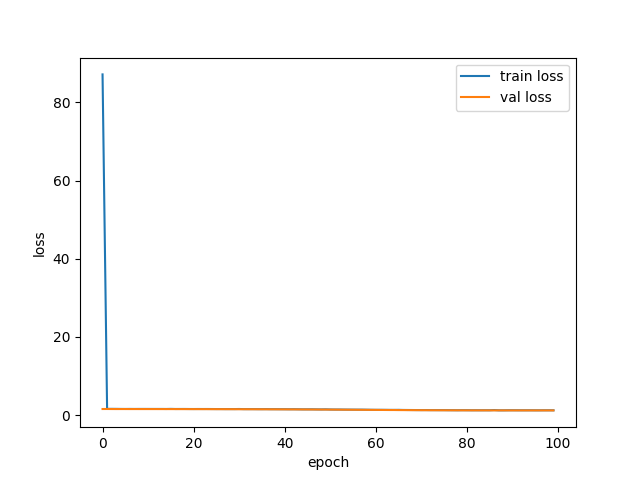

________________________________________________________________________________
Learning rate: 1e-05
Validation loss: 1.1


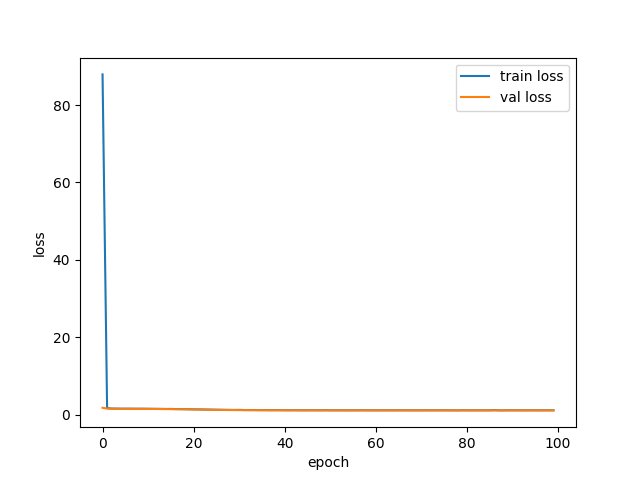

________________________________________________________________________________
Learning rate: 1e-06
Validation loss: 0.6


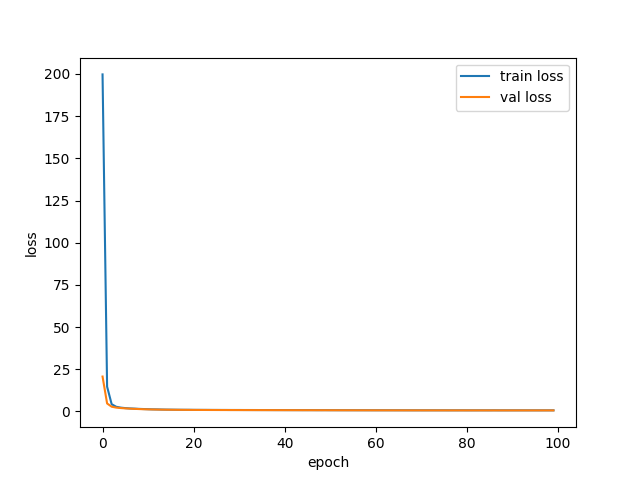

________________________________________________________________________________
Learning rate: 1e-07
Validation loss: 2.2


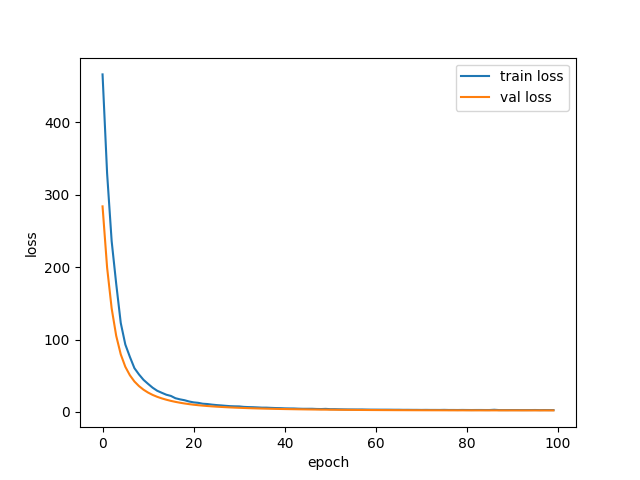

In [10]:
# display a png image
from IPython.display import Image, display
for _, (lr, loss) in lr_df.iterrows():
    img = Image(filename=f'results/loss_plots/loss_lr_{lr}_20240116.png')
    print('_'*80)
    print(f'Learning rate: {lr}')
    print(f'Validation loss: {loss:.1f}')
    display(img)

The first training loss is too large. I then plot the loss curve focusing in small loss part to see the covergence behavior in more details.

________________________________________________________________________________
Learning rate: 0.0001
Validation loss: 1.2


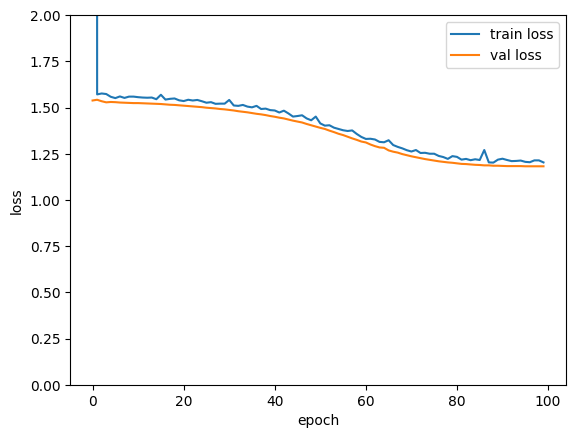

________________________________________________________________________________
Learning rate: 1e-05
Validation loss: 1.1


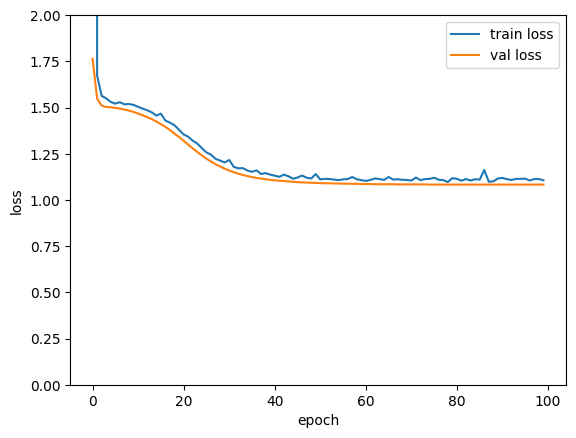

________________________________________________________________________________
Learning rate: 1e-06
Validation loss: 0.6


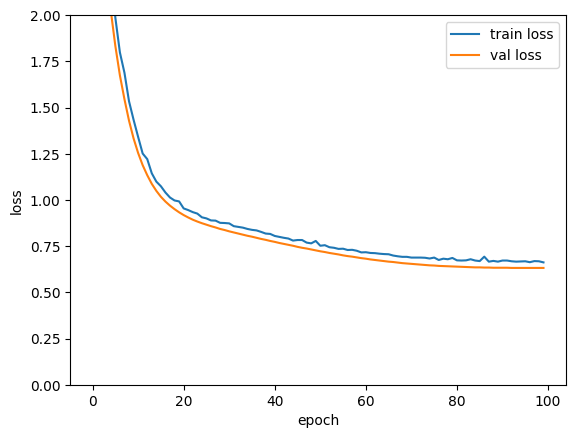

________________________________________________________________________________
Learning rate: 1e-07
Validation loss: 2.2


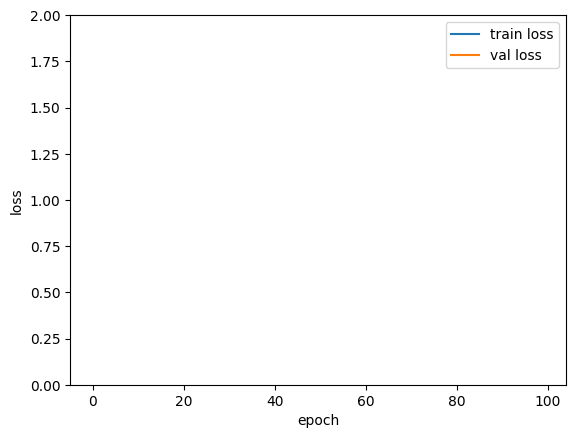

In [16]:
from util.data_analysis import get_logs, plot_loss

for _, (lr, loss) in lr_df.iterrows():
    print('_'*80)
    print(f'Learning rate: {lr}')
    print(f'Validation loss: {loss:.1f}')
    logs_df = get_logs(f'results/logs/logs_lr_{lr}_20240116.txt')
    plot_loss(logs_df.train_loss, logs_df.val_loss, ylim=(0, 2))

The model with base lr 1e-6 converges faster and gives the lowest loss. Its loss trend is still decreasing in a slow rate. Increasing epochs may help, but minor. 

## Evaluate the optimal model
I choose the optimal model (base lr 1e-6) to see more detailed performance on the validation set.

In [1]:
import torch
from models_regressor import mae_vit_base_patch16
from util.datasets import get_dataloader, standardize

device = torch.device('cuda')
model = mae_vit_base_patch16(pretrained=True).to(device)
checkpoint = torch.load('models/mae_base_patch16_lr_1e-06_20240116.pth')
model.load_state_dict(checkpoint['model_state_dict'])

dataloader = get_dataloader(ispretrain=False, annotations_file='info_20240116.csv', input_dir='data/finetune/train', 
                            batch_size=256, transform=standardize)

In [2]:
from util.evaluate import finetune_evaluator 

eva = finetune_evaluator()
model_mse = eva.evaluate(model=model, dataloader=dataloader['val'])
base_mse = eva.evaluate_base(dataloader['val'])

r_square = 1 - model_mse / base_mse

print('CaCO3, TOC')
print(f'MSE: {model_mse}')
print(f'RMSR: {model_mse**0.5}')
print(f'MSE of base model: {base_mse}')
print(f'R2: {r_square}')

CaCO3, TOC
MSE: [1.5950357e+02 5.2926220e-02]
RMSR: [12.629473    0.23005699]
MSE of base model: [3.35099642e+02 6.67947908e-02]
R2: [0.52401152 0.20762953]


## Summary
Comparing to the model without target standardization, the $TOC$ performance is improved greatly (-0.38 to 0.21). However, the $CaCO_3$ performance drops significantly (0.91 to 0.52). Perhaps, finetuning separately for different downstream tasks is more efficient. 

At this point, I have implemented the whole process from pretraining to finetuning. I should stop here to document the achievements and discuss about the next steps: advanced scale of hyperparameter training on the TWCC.